In [1]:
import os
import zipfile
import random
import shutil
import glob
import time
import re
import math
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from keras import applications
from keras.applications.densenet import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, CSVLogger
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense,  Activation, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop

from keras.applications.nasnet import decode_predictions

# 生成随机函数
random.seed(3)

Using TensorFlow backend.


### 解压数据

In [5]:
# 解压数据
train_zip = "source/kaggle_dogs_vs_cats/train.zip"
test_zip = "source/kaggle_dogs_vs_cats/test.zip"

train_upzip = zipfile.ZipFile(train_zip, 'r')
train_upzip.extractall("data/kaggle")
train_upzip.close()

test_upzip = zipfile.ZipFile(test_zip, 'r')
test_upzip.extractall("data/kaggle")
test_upzip.close()

In [6]:
# 把train训练集的猫狗图片分开并在每个文件夹下再分为训练集和验证集。
base_data_kaggle = "data/kaggle"

# 建kaggle提供的train训练集分为训练集和验证集
train_dir = os.path.join(base_data_kaggle, 'train')
valid_dir = os.path.join(base_data_kaggle, 'valid')

# 训练集内，将猫狗分开到不同的文件夹内。
train_cat_dir = os.path.join(train_dir, 'cat')
train_dog_dir = os.path.join(train_dir, 'dog')

# 验证集内，将猫狗分开到不同的文件夹内。
valid_cat_dir = os.path.join(valid_dir, 'cat')
valid_dog_dir = os.path.join(valid_dir, 'dog')

In [7]:
# 创建文件夹
sub_folders = [train_cat_dir, train_dog_dir, valid_cat_dir, valid_dog_dir]
for i in sub_folders:
    os.makedirs(i, exist_ok=True)

In [8]:
# 将所有图片地址转到一个list内。
tmp_train= glob.glob(base_data_kaggle + "/train/*.jpg")

# 设置验证集比例。
valid_ratio = 0.25

# 移动图片到相应文件夹下。
for i in tmp_train:
    if random.random() < valid_ratio:
        dir01 = 'valid'
        if os.path.basename(i).startswith('cat'):
            dir02 = 'cat'
        else:
            dir02 = 'dog'
    else:
        dir01 = 'train'
        if os.path.basename(i).startswith('cat'):
            dir02 = 'cat'
        else:
            dir02 = 'dog'
            
    dst_dir = os.path.join(base_data_kaggle, dir01, dir02)
    shutil.move(i, dst_dir)
        

### 设置小数据集

In [9]:
# 单分一个小数据集快速做测试用。

base_data_kaggle_small = "data/kaggle_small"

# 建kaggle提供的train训练集分为训练集和验证集
train_dir_small = os.path.join(base_data_kaggle_small, 'train')
valid_dir_small = os.path.join(base_data_kaggle_small, 'valid')

# 训练集内，将猫狗分开到不同的文件夹内。
train_cat_dir_small = os.path.join(train_dir_small, 'cat')
train_dog_dir_small = os.path.join(train_dir_small, 'dog')

# 验证集内，将猫狗分开到不同的文件夹内。
valid_cat_dir_small = os.path.join(valid_dir_small, 'cat')
valid_dog_dir_small = os.path.join(valid_dir_small, 'dog')

In [10]:
# 创建测试小数据集文件夹
sub_folders = [train_cat_dir_small, train_dog_dir_small, valid_cat_dir_small, valid_dog_dir_small]
for i in sub_folders:
    os.makedirs(i, exist_ok=True)

In [11]:
# 将小数据集 train内cat,dog文件夹内的图片分别导到两个list内，再合并成一个list
cat_small_tmp = glob.glob(train_dir + "/cat/*.jpg")
dog_small_tmp = glob.glob(train_dir + "/dog/*.jpg")
small_tmp = [cat_small_tmp, dog_small_tmp]

# 在train/cat,train/dog内分别提取1200张图片作为小的训练集用。
for c in small_tmp:
    for i in range(1200):
        if random.random() < valid_ratio:
            dir01 = 'valid'
            if os.path.basename(c[i]).startswith('cat'):
                dir02 = 'cat'
            else:
                dir02 = 'dog'
        else:
            dir01 = 'train'
            if os.path.basename(c[i]).startswith('cat'):
                dir02 = 'cat'
            else:
                dir02 = 'dog'

        dst_dir = os.path.join(base_data_kaggle_small, dir01, dir02)
        shutil.copy(c[i], dst_dir)

## 切换数据集

In [70]:
# 如果训练正式数据集为1，小数据集为0.
bigdata = 1

model_cache_clean_topless = 'model_densnet_no_top_densnet_v05.h5'
# 切换正式数据集和小数据集的变量。
if bigdata:
    # 正式数据集路径
    base_data_kaggle = "data/kaggle"
    train_dir = os.path.join(base_data_kaggle, 'train')
    valid_dir = os.path.join(base_data_kaggle, 'valid')
    train_cat_dir = os.path.join(train_dir, 'cat')
    train_dog_dir = os.path.join(train_dir, 'dog')
    valid_cat_dir = os.path.join(valid_dir, 'cat')
    valid_dog_dir = os.path.join(valid_dir, 'dog')
    test_dir = os.path.join(base_data_kaggle, 'test')
    
    train_bottleneck_cache = 'train_bottleneck_densnet_v05.npy'
    valid_bottleneck_cache = 'valid_bottleneck_densnet_v05.npy'
    test_bottleneck_cache = 'test_bottleneck_densnet_v05.npy'
    checkpoint_weight_cache = 'weights.best.densnet169_v05_02.hdf5'

else:
    # 小型测试数据集路径
    base_data_kaggle = "data/kaggle_small"
    train_dir = os.path.join(base_data_kaggle, 'train')
    valid_dir = os.path.join(base_data_kaggle, 'valid')
    train_cat_dir = os.path.join(train_dir, 'cat')
    train_dog_dir = os.path.join(train_dir, 'dog')
    valid_cat_dir = os.path.join(valid_dir, 'cat')
    valid_dog_dir = os.path.join(valid_dir, 'dog')
    test_dir = os.path.join(base_data_kaggle, 'test')

    train_bottleneck_cache = 'train_bottleneck_small_densnet_v05.npy'
    valid_bottleneck_cache = 'valid_bottleneck_small_densnet_v05.npy'
    test_bottleneck_cache = 'test_bottleneck_densnet_v05.npy'
    checkpoint_weight_cache = 'weights.best.densnet169_small_v05.hdf5'

## 清理数据，查找非猫狗图片

In [3]:
# ImageNet 内属于猫狗的category。
dogs = [
 'n02085620','n02085782','n02085936','n02086079','n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364','n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721','n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339','n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258','n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437','n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105','n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236','n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177','n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251','n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550','n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089','n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185','n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889','n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712','n02113799','n02113978']

cats=[
'n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']

c_d = dogs + cats

In [7]:
# 用与训练模型InceptionV32和InceptionResNetV2做筛选
model_pred_cache = 'model_pred_InceptionResNetV2.h5'
model_pred_cache_2 = 'model_pred_InceptionV32.h5'

In [ ]:
model_pred = applications.InceptionResNetV2(weights='imagenet')
# model_pred.save(model_pred_cache)

In [ ]:
model_pred_2 = applications.inception_v3.InceptionV3(weights='imagenet')
# model_pred_2.save(model_pred_cache_2)

In [8]:
# 读取InceptionResNet cache。
model_pred = load_model(model_pred_cache)

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\wangxiaowei\AppData\Local\Continuum\anaconda3\envs\keras2\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [22]:
# 读取InceptionV3 cache。
model_pred_2 = load_model(model_pred_cache_2)

In [9]:
# 如果batch size是32会提示显存不够，所以这里用16.
batch_size_pre = 16
image_size_pre = (299, 299)

ROWS = 299
COLS = 299
CHANNELS = 3

In [12]:
# 获取要预测的图片路径list。
imgs_pred = glob.glob(train_dir+'/*/*.jpg') + glob.glob(valid_dir+'/*/*.jpg')

def read_img(img):
    # 将单个图片转成numpy格式，并且归一化。
    img1 = cv2.imread(img, cv2.IMREAD_COLOR)
    img1 = cv2.resize(img1, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
    b,g,r = cv2.split(img1)
    
    #归一化
    return np.true_divide(cv2.merge([r,g,b]),255)

def prep_data(images):
    # 将图片列表转成numpy array。
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float64)

    for i, image_file in enumerate(images):
        image = read_img(image_file)
        data[i] = image
        if i%2000 == 0: print('Processed {} of {}'.format(i, count))
    return data

# 把图片list转成numpy array。
pred_imgs = prep_data(imgs_pred)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000


In [13]:
# 用InceptionResNetV2预测
train_pred_result_1 = model_pred.predict(pred_imgs, 
                                        batch_size = batch_size_pre,
                                        verbose=1
                                        )

25000/25000 [==============================] - 572s 23ms/step


In [16]:
# 解码
decode=decode_predictions(train_pred_result_1, top=30)

In [17]:
# 筛选没有被识别成猫狗的图片。

def guess(train_imgs, c_d, decode):
    # 如果识别出的类别不在上边猫狗的列表里就加到probs list内，
    # 如果probs 长度等于 top的长度说明top范围内一个都没识别成猫狗，那么
    # 很有可能不是猫狗图片，把它放到wrong list内。
    wrong=[]
    for c in range(len(train_imgs)):
        probs = []
        for p in decode[c]:
            if p[0] not in c_d:
                probs.append(p)
        if len(probs) == len(decode[c]):
            wrong.append([train_imgs[c], probs, sum([i[2] for i in probs])])
        if c > len(train_imgs):
            break
    return wrong

In [18]:
def show_guess(wrong):
    # 将wrong内的图片显示出来。
    probs_total = [i[2] for i in wrong]
    probs_total_sort = sorted(probs_total, reverse=True)

    fig=plt.figure(figsize=(12,82))
    for i in range(len(probs_total)):
        ax = fig.add_subplot(19,5,1+i)
        filename = wrong[probs_total.index(probs_total_sort[i])][0]
        ax.set_title('{}\n{:0.4f}'.format(filename.split('\\')[-3:], probs_total_sort[i]))
        image = imread(filename)
        plt.imshow(image)

    # plt.tight_layout()
    plt.show()

In [19]:
# 筛选不是猫狗的图片。
wrong = guess(imgs_pred, c_d, decode)

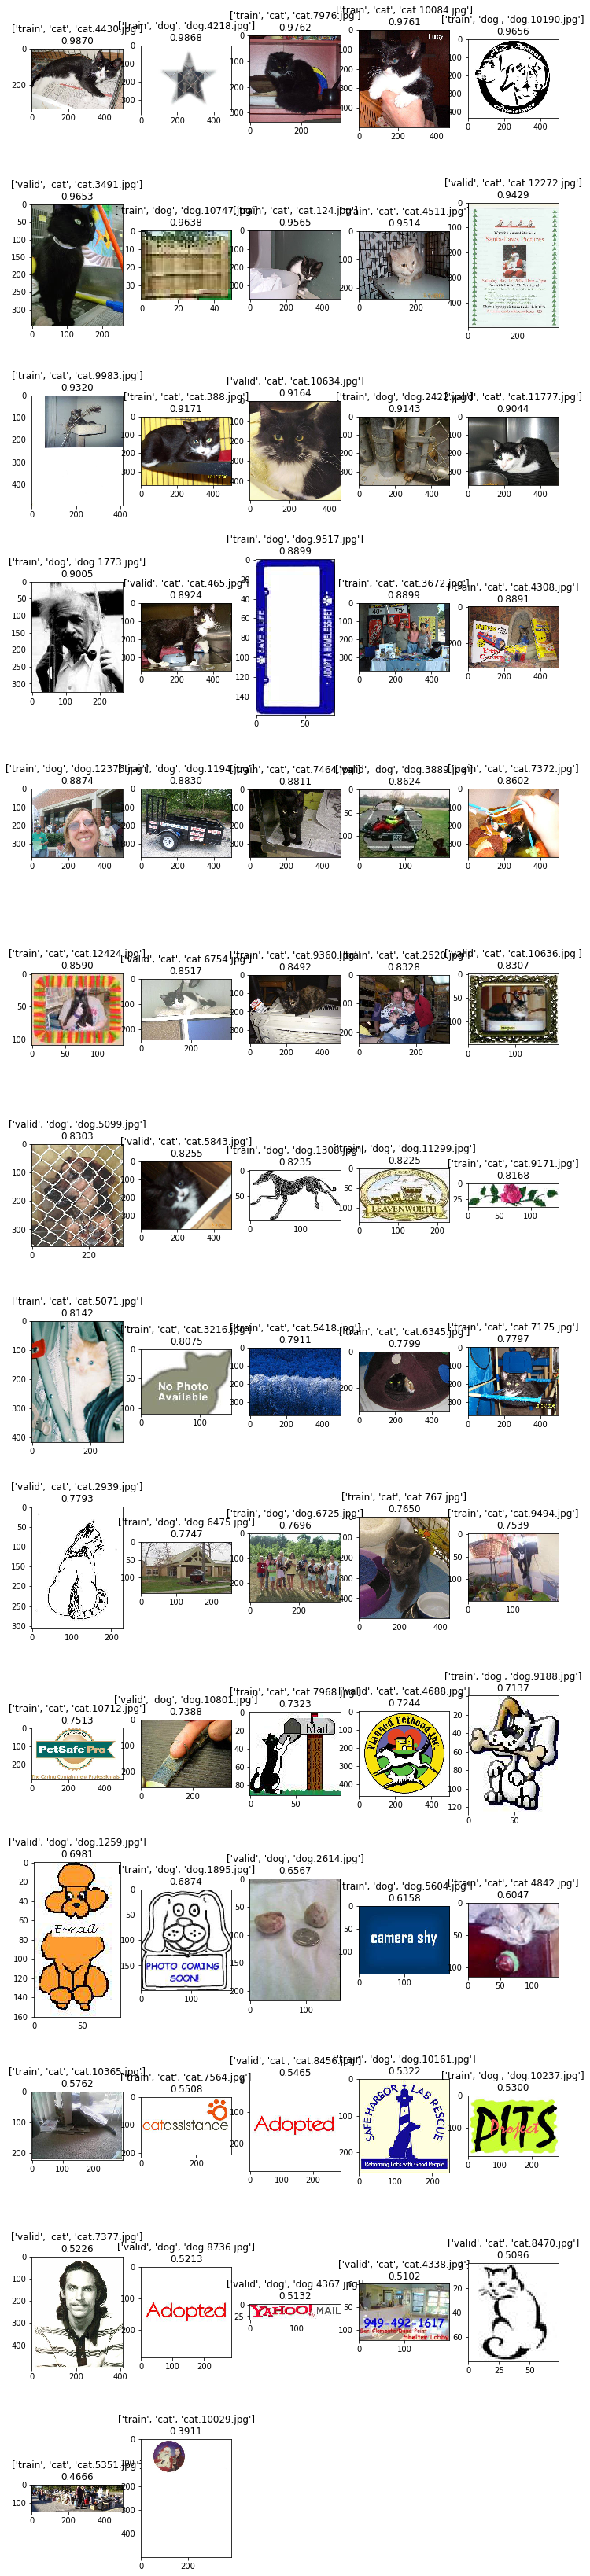

In [20]:
# 显示不是猫狗的图片。
show_guess(wrong)

In [23]:
# 用InceptionResNetV2预测。
train_pred_result_2 = model_pred_2.predict(pred_imgs, 
                           batch_size = batch_size_pre,
                           verbose=1
                           )

25000/25000 [==============================] - 290s 12ms/step


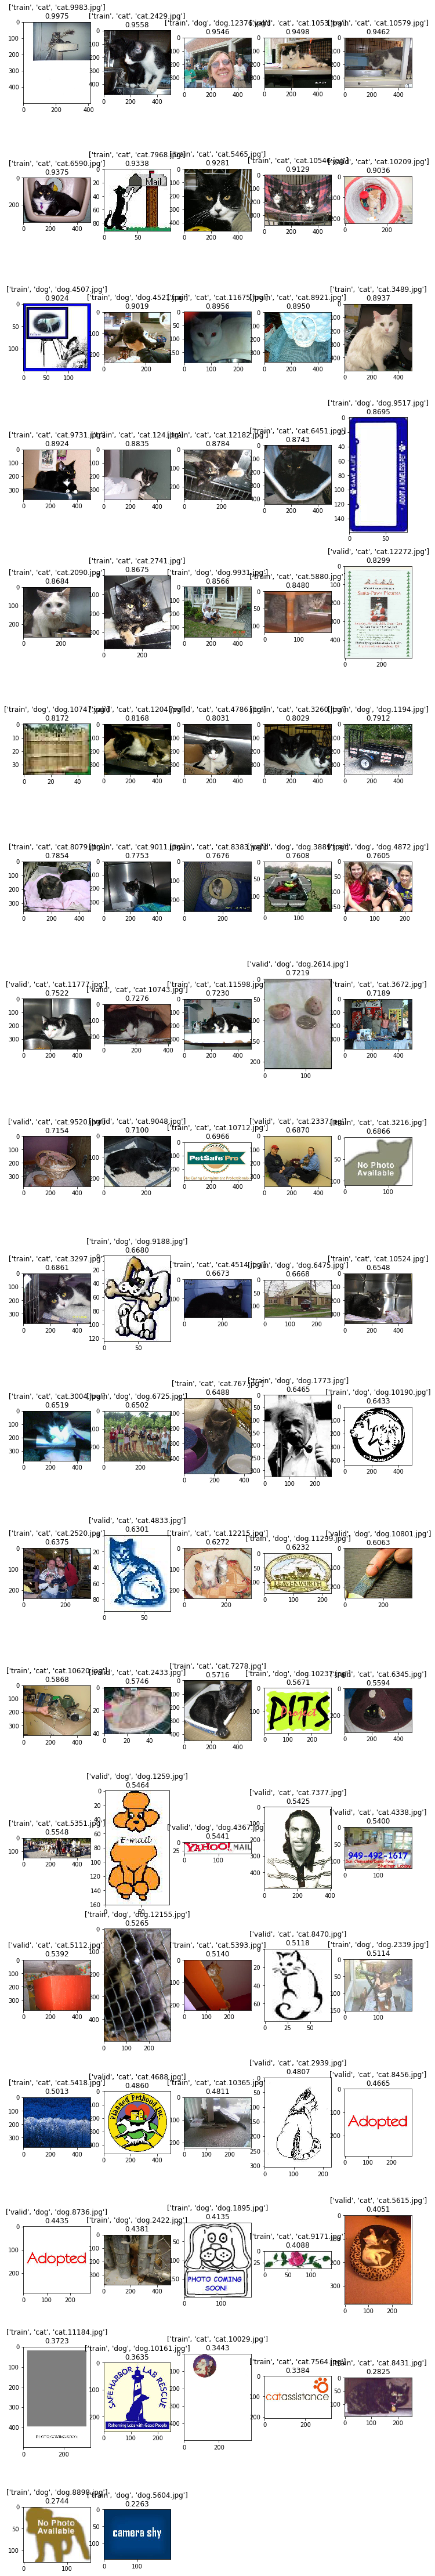

In [24]:
# 解码。
decode_2 = decode_predictions(train_pred_result_2, top=20)

# 筛选没有识别成猫狗的图片。
wrong_2 = guess(imgs_pred, c_d, decode_2)

#显示没识别成猫狗的图片。
show_guess(wrong_2)

In [29]:
# 手动摘出错误的图片，然后移动到外边的文件夹。

train_noise = [
 'cat.10029.jpg', 'cat.10365.jpg', 'cat.10712.jpg', 'cat.11184.jpg', 'cat.2520.jpg', 'cat.3216.jpg', 
 'cat.3672.jpg', 'cat.4842.jpg', 'cat.5351.jpg', 'cat.5418.jpg', 'cat.7564.jpg', 'cat.7968.jpg', 
 'cat.9171.jpg', 'dog.10161.jpg', 'dog.10190.jpg', 'dog.10237.jpg', 'dog.10747.jpg', 'dog.10190.jpg', 'dog.11299.jpg',
 'dog.1194.jpg', 'dog.12376.jpg', 'dog.1308.jpg', 'dog.1773.jpg', 'dog.1895.jpg', 'dog.4872.jpg', 'dog.5604.jpg',
 'dog.6475.jpg', 'dog.6725.jpg', 'dog.8898.jpg', 'dog.9188.jpg', 'dog.9517.jpg', 'dog.9931.jpg', 'dog.4218.jpg'
]

valid_noise = [
 'cat.12272.jpg', 'cat.8470.jpg', 'cat.4338.jpg', 'dog.4367.jpg', 'dog.8736.jpg', 'cat.7377.jpg', 'cat.8456.jpg',
 'dog.2614.jpg', 'dog.1259.jpg', 'cat.4688.jpg', 'dog.10801.jpg', 'cat.2939.jpg', 'dog.3889.jpg', 'cat.12272.jpg',
 'cat.2337.jpg', 'cat.4833.jpg'
 ]

noise = set(train_noise + valid_noise)
len(noise)

47

In [30]:
# 将不是猫狗或对训练有干扰的图片移到外边文件夹。
noise_lst = [(train_noise, 'train'), (valid_noise, 'valid')]
try:
    for a in noise_lst:
        for i in a[0]:
            if 'cat' in i:
                shutil.move(os.path.join(base_data_kaggle, a[1], 'cat', i), os.path.join(base_data_kaggle, 'noise',i))
            else:
                shutil.move(os.path.join(base_data_kaggle, a[1], 'dog', i), os.path.join(base_data_kaggle, 'noise',i))
except FileNotFoundError:
    pass

## 数据可视化

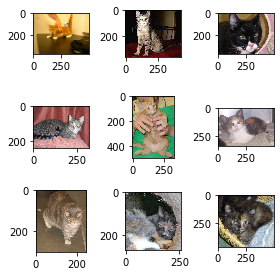

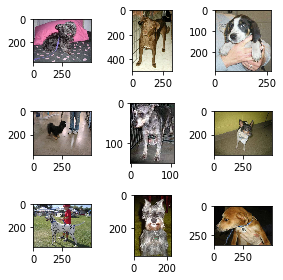

In [3]:
# 检查数据集
plt_img = glob.glob(base_data_kaggle + '/valid/cat/*.jpg')
fig=plt.figure(figsize=(4,4))
for i in range(9):
    fig.add_subplot(330+1+i)
    filename = plt_img[i]
    image = imread(filename)
    plt.imshow(image)
plt.tight_layout()
plt.show()

plt_img = glob.glob(base_data_kaggle + '/train/dog/*.jpg')
fig=plt.figure(figsize=(4,4))
for i in range(9):
    fig.add_subplot(330+1+i)
    filename = plt_img[i]
    image = imread(filename)
    plt.imshow(image)
    
plt.tight_layout()
plt.show()

## 可视化图片尺寸

In [5]:
valid_vis = glob.glob(base_data_kaggle + '/valid/*/*.jpg') 
train_vis = glob.glob(base_data_kaggle + '/train/*/*.jpg') 
test_vis = glob.glob(base_data_kaggle + '/test/*/*.jpg')

img_vis = valid_vis + train_vis + test_vis

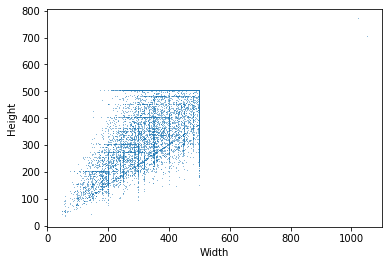

In [7]:
sizes = [imread(i).shape[:2] for i in train_vis]
y, x=zip(*sizes)
# print(y)
len(sizes)

# 显示测试结果
plt.plot(x,y,',',alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

## 用数据增强生成更多数据

In [32]:

# 通过keras的数据增强生成更多的数据。

batch_size = 16
image_size = (224, 224)

train_num = len(glob.glob(train_dir+'/*/*.jpg'))
valid_num = len(glob.glob(valid_dir+'/*/*.jpg'))
test_num = len(glob.glob(test_dir+'/*/*.jpg'))

# 图像增强设置
cache_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=25,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.05,
                                  zoom_range=0.15,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

cache_batch = cache_datagen.flow_from_directory(train_dir,
                                               target_size=image_size,
                                               interpolation='bicubic',
                                               class_mode='binary',
                                               shuffle=True,
                                               batch_size=batch_size,
#                                                 save_to_dir='data/cache',
                                                save_format='jpg',
                                               )

# 生成更多的图片到本地。
i=0
c_id=30000
d_id=30000
for img, idx in cache_batch:
#     print(idx)
    for n in range(len(idx)):
        if idx[n] == 1:
            d_id+=1
            path='data/aug/dog/dog.'+ str(d_id)+'.jpg'
        else:
            c_id+=1
            path='data/aug/cat/cat.'+ str(c_id)+'.jpg'
            
        a = array_to_img(img[n])
        b = save_img(path, a, file_format='jpeg')
        
    i += 1
    if i >(10000//16):
        break


Found 18763 images belonging to 2 classes.


## 设置基础模型（Baseline）

In [3]:
batch_size_baseline = 32
image_size_baseline = (224, 224)


train_num_baseline = len(glob.glob(train_dir+'/*/*.jpg'))
valid_num_baseline = len(glob.glob(valid_dir+'/*/*.jpg'))
test_num_baseline = len(glob.glob(test_dir+'/*/*.jpg'))

# 训练集图像增强
train_datagen_baseline = ImageDataGenerator(rescale=1./255,
                                  rotation_range=15,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  )

train_batch_baseline = train_datagen_baseline.flow_from_directory(train_dir,
                                               target_size=image_size_baseline,
                                               interpolation='bicubic',
                                               class_mode='binary',
                                               shuffle=True,
                                               batch_size=batch_size_baseline,
                                               )

# 验证集图像增强。
valid_datagen_baseline = ImageDataGenerator(rescale=1./255)

valid_batch_baseline = valid_datagen_baseline.flow_from_directory(valid_dir,
                                               target_size=image_size_baseline,
                                               interpolation='bicubic',
                                               class_mode='binary',
                                               shuffle=True,
                                               batch_size=batch_size_baseline,
                                               )



Found 2126 images belonging to 2 classes.
Found 589 images belonging to 2 classes.


(224, 224, 3)


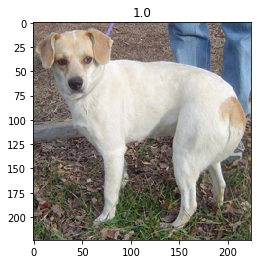

In [4]:
# 检验设置是否正确
c = 0
for i in valid_batch_baseline:
    print(i[0][0].shape)
    img = array_to_img(i[0][0])
    plt.imshow(img)
    plt.title(i[1][0])
    c +=1
    if c >0:
        break

In [5]:
# 搭建基础模型网络
input_shape_baseline = (224, 224, 3)

# del model_b
model_b = Sequential()

model_b.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape_baseline, activation='relu'))
model_b.add(MaxPooling2D(pool_size=(2, 2)))

model_b.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_b.add(MaxPooling2D(pool_size=(2, 2)))

model_b.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_b.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_b.add(MaxPooling2D(pool_size=(2, 2)))

model_b.add(Flatten())
model_b.add(Dense(64, activation='relu'))
model_b.add(Dropout(0.5))

model_b.add(Dense(1))
model_b.add(Activation('sigmoid'))

model_b.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
epoch_baseline = 25

# 将log信息存在csv文件里。

csv_logger_baseline = CSVLogger('log_baseline.csv', append=False, separator=',')
checkpointer_baseline = ModelCheckpoint(filepath='baseline_weights.hdf5', verbose=1, save_best_only=True)
earlystop_baseline = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')     

fit_log_baseline = model_b.fit_generator(
                      train_batch_baseline, 
                      epochs=epoch_baseline, 
                      steps_per_epoch=math.ceil(train_num_baseline/batch_size_baseline),
                      validation_data=valid_batch_baseline,
                      validation_steps=math.ceil(valid_num_baseline/batch_size_baseline),
                      callbacks=[checkpointer_baseline, csv_logger_baseline, earlystop_baseline])



Instructions for updating:
Use tf.cast instead.
Epoch 1/25
67/67 [==============================] - 46s 686ms/step - loss: 0.7098 - acc: 0.5185 - val_loss: 0.6889 - val_acc: 0.5705

Epoch 00001: val_loss improved from inf to 0.68889, saving model to baseline_weights.hdf5
Epoch 2/25
67/67 [==============================] - 43s 647ms/step - loss: 0.6905 - acc: 0.5386 - val_loss: 0.6871 - val_acc: 0.5518

Epoch 00002: val_loss improved from 0.68889 to 0.68710, saving model to baseline_weights.hdf5
Epoch 3/25
67/67 [==============================] - 45s 665ms/step - loss: 0.6862 - acc: 0.5751 - val_loss: 0.6799 - val_acc: 0.5891

Epoch 00003: val_loss improved from 0.68710 to 0.67988, saving model to baseline_weights.hdf5
Epoch 4/25
67/67 [==============================] - 44s 657ms/step - loss: 0.6734 - acc: 0.5729 - val_loss: 0.6727 - val_acc: 0.5756

Epoch 00004: val_loss improved from 0.67988 to 0.67269, saving model to baseline_weights.hdf5
Epoch 5/25
67/67 [==========================

## 正式训练
## 设置Generator

In [54]:
batch_size = 16
image_size = (224, 224)

train_num = len(glob.glob(train_dir+'/*/*.jpg'))
valid_num = len(glob.glob(valid_dir+'/*/*.jpg'))
test_num = len(glob.glob(test_dir+'/*/*.jpg'))

# 训练集图像增强
train_datagen = ImageDataGenerator(
#                                   rescale=1./255,
                                  rotation_range=35,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.15,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  data_format='channels_last',
                                  preprocessing_function=preprocess_input
                                  )

train_batch = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_size,
                                               interpolation='bicubic',
                                               class_mode='binary',
                                               shuffle=False,
                                               batch_size=batch_size,
                                               )

# 验证集图像增强。
valid_datagen = ImageDataGenerator(
#                                     rescale=1./255,
                                   data_format='channels_last',
                                   preprocessing_function=preprocess_input
                                  )

valid_batch = valid_datagen.flow_from_directory(valid_dir,
                                               target_size=image_size,
                                               interpolation='bicubic',
                                               class_mode='binary',
                                               shuffle=False,
                                               batch_size=batch_size,
#                                                seed=3
                                               )

# 生成 test bottleneck 缓存数据
test_datagen = ImageDataGenerator(
#                                   rescale=1./255,
                                  data_format='channels_last',
                                  preprocessing_function=preprocess_input
                                 )

test_batch = test_datagen.flow_from_directory(test_dir,
                                               target_size=image_size,
                                               interpolation='bicubic',
                                               class_mode=None,
                                               shuffle=False,
                                               batch_size=batch_size,
                                             )

Found 25760 images belonging to 2 classes.
Found 9210 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [5]:
# 确认标签。
print('****************')
for cls, idx in train_batch.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

****************
Class #0 = cat
Class #1 = dog
****************


## 训练模型

In [4]:
t = time.time()
# del model

# 导入densenet模型
model = applications.DenseNet169(include_top=False, weights='imagenet',input_shape=(224, 224, 3))

# cache原始模型以备后续重复使用。
model.save(model_cache_clean_topless)
print(time.time() - t)

Instructions for updating:
Colocations handled automatically by placer.
148.64086270332336


In [55]:
t = time.time()
# del model

# 读取cache的原始模型。
model = load_model(model_cache_clean_topless)
print(time.time() - t)

57.3347327709198


C:\Users\wangxiaowei\AppData\Local\Continuum\anaconda3\envs\keras2\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
# model.summary()

### 生成bottleneck

In [56]:
t = time.time()
train_bottleneck = model.predict_generator(train_batch, math.ceil(train_num/batch_size), verbose=1)
np.save(open(train_bottleneck_cache, 'wb'), train_bottleneck)
print(time.time() - t)

1610/1610 [==============================] - 530s 329ms/step
907.0556964874268


In [57]:
t = time.time()
valid_bottleneck = model.predict_generator(valid_batch, math.ceil(valid_num/batch_size), verbose=1)
np.save(open(valid_bottleneck_cache, 'wb'), valid_bottleneck)
print(time.time() - t)

576/576 [==============================] - 121s 210ms/step
250.47104454040527


In [46]:
# !!!!!保存test bottleneck数据

t = time.time()
test_bottleneck = model.predict_generator(test_batch, math.ceil(test_num/batch_size), verbose=1)
valid_data = np.save(open(test_bottleneck_cache, 'wb'), test_bottleneck)
print(time.time()-t)

782/782 [==============================] - 157s 201ms/step
336.62165880203247


### 读取bottleneck缓存

In [58]:
train_data = np.load(open(train_bottleneck_cache, 'rb'))
valid_data = np.load(open(valid_bottleneck_cache, 'rb'))

In [47]:
test_data = np.load(open(test_bottleneck_cache, 'rb'))

### 获取label

In [59]:
train_label=train_batch.classes[:train_data.shape[0]]
valid_label=valid_batch.classes[:valid_data.shape[0]]

In [71]:
t = time.time()

epochs=100

# del model_x
model_x = Sequential()
model_x.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
model_x.add(Dense(60, activation='relu'))
model_x.add(Dropout(0.5))
model_x.add(Dense(30, activation='relu'))
model_x.add(Dropout(0.4))
model_x.add(Dense(1, activation='sigmoid'))


optimizer = SGD(lr=0.0001, momentum=0.9, decay=0.00001)
optimizer2 = Adam(lr=0.0005)

model_x.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

# 将log信息存在csv文件里。
csv_logger = CSVLogger('log_SDG_2.csv', append=False, separator=',')

checkpointer = ModelCheckpoint(filepath=checkpoint_weight_cache, verbose=1, save_best_only=True)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [72]:
# 开始训练
fit_log = model_x.fit(train_data, train_label, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(valid_data, valid_label),
                      callbacks=[checkpointer, csv_logger, earlystop])

print(time.time() - t)

Train on 25760 samples, validate on 9210 samples
Epoch 1/100
25760/25760 [==============================] - 63s 2ms/step - loss: 0.3123 - acc: 0.8663 - val_loss: 0.0664 - val_acc: 0.9824

Epoch 00001: val_loss improved from inf to 0.06639, saving model to weights.best.densnet169_v05_02.hdf5
Epoch 2/100
25760/25760 [==============================] - 52s 2ms/step - loss: 0.1390 - acc: 0.9546 - val_loss: 0.0390 - val_acc: 0.9874

Epoch 00002: val_loss improved from 0.06639 to 0.03903, saving model to weights.best.densnet169_v05_02.hdf5
Epoch 3/100
25760/25760 [==============================] - 49s 2ms/step - loss: 0.1062 - acc: 0.9673 - val_loss: 0.0350 - val_acc: 0.9869

Epoch 00003: val_loss improved from 0.03903 to 0.03499, saving model to weights.best.densnet169_v05_02.hdf5
Epoch 4/100
25760/25760 [==============================] - 49s 2ms/step - loss: 0.0936 - acc: 0.9713 - val_loss: 0.0292 - val_acc: 0.9890

Epoch 00004: val_loss improved from 0.03499 to 0.02919, saving model to wei

25760/25760 [==============================] - 50s 2ms/step - loss: 0.0369 - acc: 0.9885 - val_loss: 0.0187 - val_acc: 0.9927

Epoch 00038: val_loss improved from 0.01878 to 0.01875, saving model to weights.best.densnet169_v05_02.hdf5
Epoch 39/100
25760/25760 [==============================] - 49s 2ms/step - loss: 0.0368 - acc: 0.9878 - val_loss: 0.0189 - val_acc: 0.9928

Epoch 00039: val_loss did not improve from 0.01875
Epoch 40/100
25760/25760 [==============================] - 49s 2ms/step - loss: 0.0378 - acc: 0.9882 - val_loss: 0.0190 - val_acc: 0.9928

Epoch 00040: val_loss did not improve from 0.01875
Epoch 41/100
25760/25760 [==============================] - 48s 2ms/step - loss: 0.0380 - acc: 0.9879 - val_loss: 0.0191 - val_acc: 0.9928

Epoch 00041: val_loss did not improve from 0.01875
Epoch 42/100
25760/25760 [==============================] - 49s 2ms/step - loss: 0.0363 - acc: 0.9885 - val_loss: 0.0190 - val_acc: 0.9929

Epoch 00042: val_loss did not improve from 0.01875
E

25760/25760 [==============================] - 49s 2ms/step - loss: 0.0299 - acc: 0.9919 - val_loss: 0.0179 - val_acc: 0.9935

Epoch 00079: val_loss improved from 0.01814 to 0.01795, saving model to weights.best.densnet169_v05_02.hdf5
Epoch 80/100
25760/25760 [==============================] - 50s 2ms/step - loss: 0.0289 - acc: 0.9910 - val_loss: 0.0180 - val_acc: 0.9935

Epoch 00080: val_loss did not improve from 0.01795
Epoch 81/100
25760/25760 [==============================] - 48s 2ms/step - loss: 0.0272 - acc: 0.9918 - val_loss: 0.0181 - val_acc: 0.9935

Epoch 00081: val_loss did not improve from 0.01795
Epoch 82/100
25760/25760 [==============================] - 47s 2ms/step - loss: 0.0287 - acc: 0.9908 - val_loss: 0.0184 - val_acc: 0.9933

Epoch 00082: val_loss did not improve from 0.01795
Epoch 83/100
25760/25760 [==============================] - 47s 2ms/step - loss: 0.0277 - acc: 0.9917 - val_loss: 0.0187 - val_acc: 0.9933

Epoch 00083: val_loss did not improve from 0.01795
E

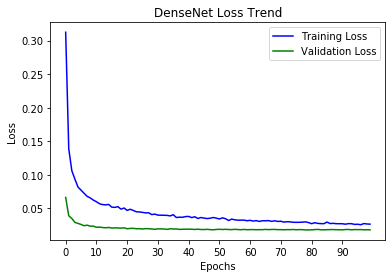

In [73]:
# 读取缓存的log文件，查看plot。

logs=pd.read_csv('log_SDG_2.csv')
loss = logs['loss']
val_loss = logs['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DenseNet Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::10])
plt.legend()
plt.show()

In [63]:
# 读取缓存的最优模型。
model_x.load_weights(checkpoint_weight_cache)

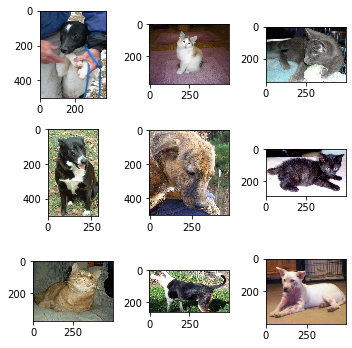

In [64]:
# 检查test数据集。
test_img = glob.glob(test_dir + '/test/*.jpg')
fig = plt.figure(figsize=(5,5))
for i in range(9):
    fig.add_subplot(330+1+i)
    filename = test_img[i]
    image = imread(filename)
    plt.imshow(image)
plt.tight_layout()
plt.show()

In [81]:
34/1314

0.0258751902587519

In [74]:
# 预测test数据集。
result = model_x.predict(test_data, verbose=1)
result[:9]

12500/12500 [==============================] - 11s 862us/step


array([[9.99999881e-01],
       [1.12354755e-05],
       [2.08616257e-07],
       [9.99999642e-01],
       [9.99989033e-01],
       [5.96046448e-08],
       [5.63263893e-06],
       [9.99998689e-01],
       [9.99765396e-01]], dtype=float32)

In [75]:
# clip一下0-1，提升效果。
result2 = np.clip(result,0.005, 0.995)

In [76]:
#生成csv文件
with open('submission.csv', 'w') as f:
    f.write('id,label\n')

with open('submission.csv', 'a') as f:
    for i in range(result2.shape[0]):
        idx = re.findall(r'\d+',test_batch.filenames[i])[0]
        label = result2[i][0]
        f.write('{},{}\n'.format(idx,label))

In [77]:
# 检查文件有没有问题。
import pandas as pd
csv = pd.read_csv('submission.csv')
csv[:10]

id  label
0      1  0.995
1     10  0.005
2    100  0.005
3   1000  0.995
4  10000  0.995
5  10001  0.005
6  10002  0.005
7  10003  0.995
8  10004  0.995
9  10005  0.005

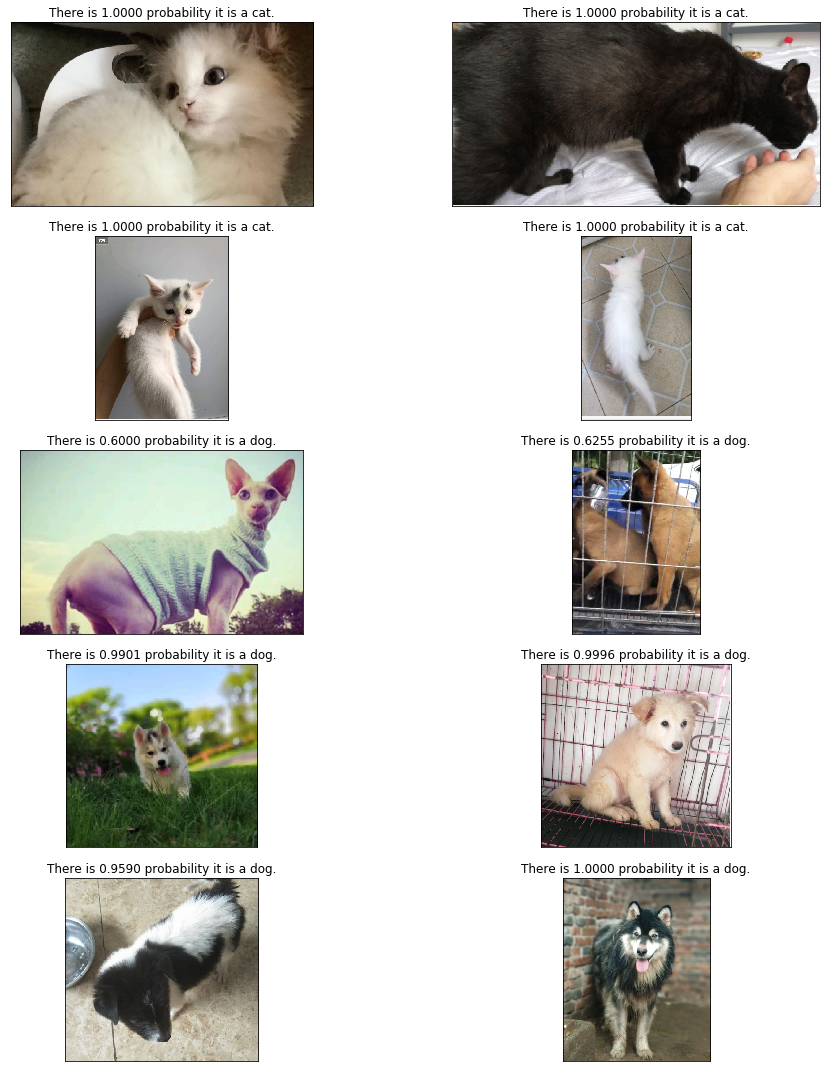

In [80]:
# 定义一个方程方便测试训练好的模型。输入一张图片，返回一个概率，如果是狗概率接近1，如果是猫概率接近0
def test_img(img, model, model_x):
    
    img = img_to_array(load_img(img,target_size=(224, 224)))
    img = np.expand_dims(img, axis=0)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_batch = test_datagen.flow(img, shuffle=False)
    
    test_data = model.predict_generator(test_batch, steps=1)
    
    result = model_x.predict(test_data, steps = 1)
    return result[0][0]

# 路径内为网上下载的猫狗图片
imgs = glob.glob(r'c:/project/machine_learning/p6/data/final_test/*.png')

# 显示测试结果
fig = plt.figure(figsize=(15,15))
for i in range(10):
    prob = test_img(imgs[i], model, model_x)
    ax = fig.add_subplot(5,2,1+i)
    if prob > 0.5:
        predict = 'dog'
        prob = prob
    else:
        predict = 'cat'
        prob = 1-prob
        
    title = 'There is {:5.4f} probability it is a {}.'.format(prob, predict)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    filename = imgs[i]
    image = imread(filename)
    plt.imshow(image)
    
plt.tight_layout()
plt.show()